In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from data.codet_m4 import CoDeTM4

In [2]:
codet = CoDeTM4('../../data/').get_dataset('all', columns='all', dynamic_split_sizing=False)

In [3]:
codet

Dataset({
    features: ['code', 'language', 'model', 'split', 'target', 'source', 'features', 'cleaned_code', '__index_level_0__', 'target_binary'],
    num_rows: 500552
})

In [4]:
set(codet['language'])

{'cpp', 'java', 'python'}

In [5]:
import matplotlib.pyplot as plt

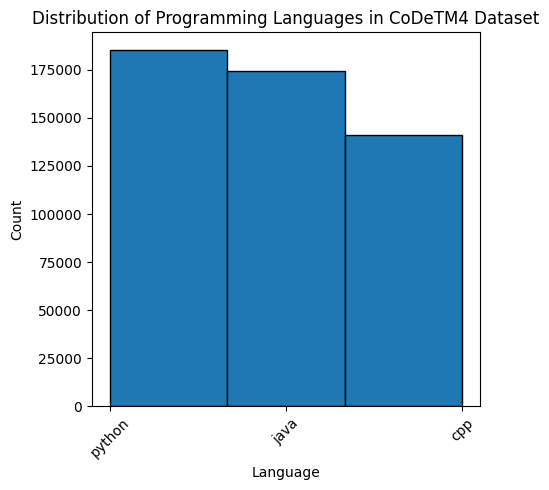

In [6]:
language_counts = codet['language']
plt.figure(figsize=(5, 5))
plt.hist(language_counts, bins=len(set(language_counts)), edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Programming Languages in CoDeTM4 Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
codet[0]['language']

'python'

In [8]:
from tree_sitter import Parser, Language
import tree_sitter_python as tspython

In [9]:
TS_PYTHON = Language(tspython.language())

In [10]:
parser = Parser(TS_PYTHON)

In [11]:
tree = parser.parse(bytes(codet[0]['code'], 'utf-8'))

In [12]:
def print_tree(node, indent=0):
    node_text = node.text.decode('utf8') if node.text else ""
    print("  " * indent + f"{node.type}: {node_text}")
    for child in node.children:
        print_tree(child, indent + 1)

print_tree(tree.root_node)

module: def order_phase_diagram(lines, stable_entries, unstable_entries, ordering):
    """
    Orders the entries (their coordinates) in a phase diagram plot according
    to the user specified ordering.
    Ordering should be given as ['Up', 'Left', 'Right'], where Up,
    Left and Right are the names of the entries in the upper, left and right
    corners of the triangle respectively.

    Args:
        lines: list of list of coordinates for lines in the PD.
        stable_entries: {coordinate : entry} for each stable node in the
            phase diagram. (Each coordinate can only have one stable phase)
        unstable_entries: {entry: coordinates} for all unstable nodes in the
            phase diagram.
        ordering: Ordering of the phase diagram, given as a list ['Up',
            'Left','Right']

    Returns:
        (newlines, newstable_entries, newunstable_entries):
        - newlines is a list of list of coordinates for lines in the PD.
        - newstable_entries is a {

In [13]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch_geometric.data import Data

In [14]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base").to('cuda')
model.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [15]:
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to('cuda')
    with torch.no_grad():
        return model(**inputs).last_hidden_state.mean(dim=1).cpu().squeeze().numpy()

def tree_to_graph(node, graph=None):
    if graph is None:
        graph = {'nodes': [], 'edges': [], 'node_texts': []}
    node_id = len(graph['nodes'])
    text = node.text.decode('utf8') if node.text else ""
    graph['nodes'].append({'id': node_id, 'type': node.type, 'text': text})
    graph['node_texts'].append(text)
    for child in node.children:
        child_id = len(graph['nodes'])
        graph['edges'].append((node_id, child_id))
        tree_to_graph(child, graph)
    return graph


In [16]:
def create_graph_with_label(code_sample, code_key='code', target_key='target_binary'):
    tree = parser.parse(bytes(code_sample[code_key], 'utf-8'))
    graph = tree_to_graph(tree.root_node)
    
    node_features = torch.tensor([get_embedding(text) for text in graph['node_texts'] if text], dtype=torch.float)
    edge_index = torch.tensor(graph['edges'], dtype=torch.long).t().contiguous()
    
    class_label = code_sample[target_key]
    
    return Data(
        x=node_features,
        edge_index=edge_index,
        y=torch.tensor([class_label], dtype=torch.long)
    )

In [17]:
data = create_graph_with_label(codet[0])

/tmp/ipykernel_20412/3260841562.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  node_features = torch.tensor([get_embedding(text) for text in graph['node_texts'] if text], dtype=torch.float)


In [18]:
data

Data(x=[2073, 768], edge_index=[2, 2072], y=[1])

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=768//2)

In [21]:
pca.fit(data['x'])

PCA(n_components=384)

In [22]:
tr = pca.transform(data['x'])

In [23]:
data['x'].shape

torch.Size([2073, 768])

In [24]:
tr

array([[-8.44254380e+00,  5.69592367e-01,  4.64217648e+00, ...,
         5.55111512e-16,  1.11022302e-16, -4.44089210e-16],
       [-8.44254380e+00,  5.69592367e-01,  4.64217648e+00, ...,
         5.55111512e-16,  1.11022302e-16, -4.44089210e-16],
       [ 3.16751537e+00,  2.83752172e+00,  8.97699174e-02, ...,
         7.77156117e-16,  3.33066907e-16,  6.66133815e-16],
       ...,
       [-4.75004879e+00, -2.21802269e+00, -2.04308346e+00, ...,
        -3.33066907e-16, -1.33226763e-15, -2.22044605e-16],
       [ 3.60684541e+00,  1.02632093e+00,  6.38598615e-02, ...,
         1.11022302e-16, -3.33066907e-16,  5.55111512e-16],
       [-5.71202489e+00, -1.96754755e+00, -2.32235025e+00, ...,
         3.33066907e-16, -1.11022302e-16, -6.66133815e-16]],
      shape=(2073, 384))

In [25]:
data['x']=tr

In [26]:
data

Data(x=[2073, 384], edge_index=[2, 2072], y=[1])

In [27]:
import numpy as np

Text(0, 0.5, 'cumulative explained variance')

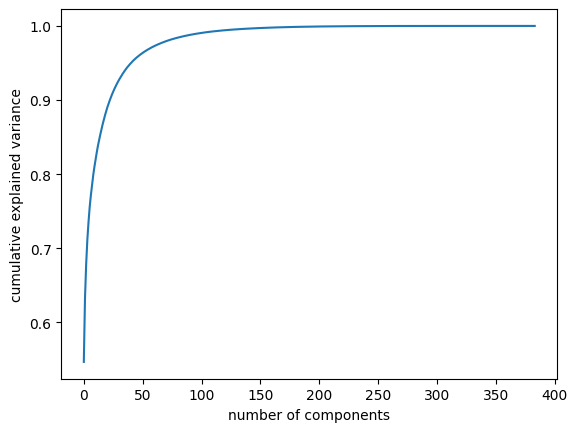

In [28]:

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [29]:
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language

In [30]:
TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

In [31]:
python_parser, java_parser, cpp_parser = Parser(language=TS_PYTHON), Parser(language=TS_JAVA), Parser(language=TS_CPP)

In [32]:
from tqdm import tqdm

In [33]:
print(codet[0]['cleaned_code'])
print('---------------------------------------------\n')
print(codet[0]['code'])

def order_phase_diagram(lines, stable_entries, unstable_entries, ordering):
    
    yup = -1000.0
    xleft = 1000.0
    xright = -1000.0

    for coord in stable_entries:
        if coord[0] > xright:
            xright = coord[0]
            nameright = stable_entries[coord].name
        if coord[0] < xleft:
            xleft = coord[0]
            nameleft = stable_entries[coord].name
        if coord[1] > yup:
            yup = coord[1]
            nameup = stable_entries[coord].name

    if (not nameup in ordering) or (not nameright in ordering) or \
            (not nameleft in ordering):
        raise ValueError(
            'Error in ordering_phase_diagram : \n"{up}", "{left}" and "{'
            'right}"'
            ' should be in ordering : {ord}'.format(up=nameup, left=nameleft,
                                                    right=nameright,
                                                    ord=ordering))

    cc = np.array([0.5, np.sqrt(3.0) / 6.0], np.float)

    

In [34]:
def get_embeddings_batch(texts, batch_size=64):
    """Get embeddings for multiple texts at once"""
    max_length = max(len(tokenizer.encode(text)) for text in texts)
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to('cuda')
        with torch.no_grad():
            batch_embeddings = model(**inputs).last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.extend(batch_embeddings)
    return embeddings

def get_parser_for_language(language):
    """Get the appropriate parser for the given language"""
    if language.lower() == 'python':
        return python_parser
    elif language.lower() == 'java':
        return java_parser
    elif language.lower() in ['c++', 'cpp', 'c']:
        return cpp_parser
    else:
        return python_parser

In [35]:
samples = codet.take(32)

def get_tree(sample, code_key='code'):
    language = sample['language']
    code = sample[code_key]
    parser = get_parser_for_language(language)
    return parser.parse(bytes(code, 'utf-8'))

for sample in samples:
    tree = get_tree(sample, code_key='cleaned_code')

In [49]:
def get_embedding_batch(texts, batch_size=32):
    """Get embeddings for texts in smaller batches to avoid OOM"""
    if not texts:
        return []
    
    all_embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512).to('cuda')
        
        with torch.no_grad():
            batch_embeddings = model(**inputs).last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.extend(batch_embeddings)
        
        # Clear GPU cache after each batch
        torch.cuda.empty_cache()
    
    return all_embeddings

In [50]:
def create_graph_with_label_batched(code_sample, code_key='code', target_key='target_binary', batch_size=32):
    # Step 1: Get the tree (you already have this)
    tree = get_tree(code_sample, code_key)
    
    # Step 2: Convert tree to graph structure
    graph = tree_to_graph(tree.root_node)
    
    # Step 3: Get all non-empty texts from the graph
    non_empty_texts = [text for text in graph['node_texts'] if text.strip()]
    
    # Step 4: Get embeddings for ALL texts in one batch call
    if non_empty_texts:
        embeddings = get_embedding_batch(non_empty_texts, batch_size)  # One GPU call instead of many
        node_features = torch.tensor(embeddings, dtype=torch.float)
    else:
        node_features = torch.empty((0, 768), dtype=torch.float)  # Handle empty case
    
    # Step 5: Create edge index
    edge_index = torch.tensor(graph['edges'], dtype=torch.long).t().contiguous()
    
    # Step 6: Get class label
    class_label = code_sample[target_key]
    
    # Step 7: Return PyG Data object
    return Data(
        x=node_features,
        edge_index=edge_index,
        y=torch.tensor([class_label], dtype=torch.long)
    )

In [38]:
data_batched = create_graph_with_label_batched(codet[0], code_key='cleaned_code')
print(data_batched)

Data(x=[2067, 768], edge_index=[2, 2066], y=[1])


In [ ]:
import time

batch_sizes = [1, 2, 4, 8,16,32,64, 128]

for size in batch_sizes:
    start = time.time()
    data_batched = create_graph_with_label_batched(codet[0], code_key='cleaned_code', batch_size=size)
    print(data_batched)
    end = time.time()

    print(f'Batch Size: {size} - Time taken: {end-start}')

Data(x=[2067, 768], edge_index=[2, 2066], y=[1])
Batch Size: 1 - Time taken: 15.156598091125488
Data(x=[2067, 768], edge_index=[2, 2066], y=[1])
Batch Size: 2 - Time taken: 9.354686260223389
Data(x=[2067, 768], edge_index=[2, 2066], y=[1])
Batch Size: 4 - Time taken: 5.598366022109985
Data(x=[2067, 768], edge_index=[2, 2066], y=[1])
Batch Size: 8 - Time taken: 4.264033794403076
Data(x=[2067, 768], edge_index=[2, 2066], y=[1])
Batch Size: 16 - Time taken: 4.096923351287842
Data(x=[2067, 768], edge_index=[2, 2066], y=[1])
Batch Size: 32 - Time taken: 5.80012583732605
Data(x=[2067, 768], edge_index=[2, 2066], y=[1])
Batch Size: 64 - Time taken: 8.583073139190674
Data(x=[2067, 768], edge_index=[2, 2066], y=[1])
Batch Size: 128 - Time taken: 13.161520004272461


In [40]:
torch.cuda.empty_cache()

In [42]:
import h5py

In [53]:
sample_embeddings = []
for sample in codet.take(1000):
    data = create_graph_with_label_batched(sample, code_key='cleaned_code', batch_size=16)
    sample_embeddings.append(data.x.numpy())

all_embeddings = np.vstack(sample_embeddings)
pca = PCA(n_components=384)
pca.fit(all_embeddings)

PCA(n_components=384)

In [62]:
def collect_texts_from_samples(samples):
    all_texts = []
    sample_info = []
    
    for sample in samples:
        # Use your existing functions
        tree = get_tree(sample, 'cleaned_code')
        graph = tree_to_graph(tree.root_node)
        texts = [text for text in graph['node_texts'] if text.strip()]
        
        # Keep track of what belongs to what
        all_texts.extend(texts)
        sample_info.append({
            'sample': sample,
            'graph': graph,
            'num_texts': len(texts)
        })
    
    return all_texts, sample_info

test_samples = list(codet.take(4))
all_texts, sample_info = collect_texts_from_samples(test_samples)
print(f"Collected {len(all_texts)} texts from {len(test_samples)} samples")

Collected 2308 texts from 4 samples


In [64]:
def distribute_embeddings_to_graphs(all_embeddings, sample_info):
    graphs = []
    embedding_idx = 0
    
    for info in sample_info:
        sample = info['sample']
        graph = info['graph']
        num_texts = info['num_texts']
        
        # Get the embeddings that belong to this graph
        if num_texts > 0:
            graph_embeddings = all_embeddings[embedding_idx:embedding_idx + num_texts]
            node_features = torch.tensor(graph_embeddings, dtype=torch.float)
            embedding_idx += num_texts
        else:
            node_features = torch.empty((0, 768), dtype=torch.float)
        
        # Create the graph structure
        edge_index = torch.tensor(graph['edges'], dtype=torch.long).t().contiguous()
        
        # Create the Data object
        data = Data(
            x=node_features,
            edge_index=edge_index,
            y=torch.tensor([sample['target_binary']], dtype=torch.long)
        )
        
        graphs.append((sample, data))
    
    return graphs

# Test it with your data
batch_graphs = distribute_embeddings_to_graphs(all_embeddings, sample_info)
print(f"Created {len(batch_graphs)} graphs")

# Check the first graph
sample, data = batch_graphs[0]
print(f"First graph: {data}")
print(f"Sample split: {sample['split']}")

Created 4 graphs
First graph: Data(x=[2067, 768], edge_index=[2, 2066], y=[1])
Sample split: train


In [63]:
# Get embeddings for ALL texts at once
if all_texts:
    all_embeddings = get_embedding_batch(all_texts, batch_size=16)
    print(f"Got {len(all_embeddings)} embeddings")

Got 2308 embeddings


In [77]:
def safe_create_dataset(hf, dataset_name, data):
    if dataset_name in hf:
        del hf[dataset_name]
    hf.create_dataset(dataset_name, data=data)

checkpoint_file = '../../data/codet_graphs/graph_progress.txt'

start_idx = 0 
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        start_idx = int(f.read().strip()) + 1
    print(f'Resuming from sample: {start_idx}')

    
with h5py.File('../../data/codet_graphs/graphs.h5', 'a') as hf:
    for i, sample in enumerate(start=start_idx, iterable=tqdm(codet.skip(start_idx), desc='Creating graphs', initial=start_idx)):
        data = create_graph_with_label_batched(sample, code_key='cleaned_code', batch_size=16)
        dataset_name = f'{sample["split"]}/node_features/graph_{i:07d}'
        safe_create_dataset(hf, dataset_name, data.x.numpy())

        dataset_name = f'{sample["split"]}/edge_indices/graph_{i:07d}'
        safe_create_dataset(hf, dataset_name, data.edge_index.numpy())

        dataset_name = f'{sample["split"]}/labels/graph_{i:07d}'
        safe_create_dataset(hf, dataset_name, data.y.numpy())

        if i % 200 == 0:
            with open(checkpoint_file, 'w') as f:
                f.write(str(i))

# batch_size = 32

# with h5py.File('../../data/codet_graphs/graphs.h5', 'a') as hf:
#     for batch_start in tqdm(range(start_idx, len(codet), 32)):
#         batch_end = min(batch_start + batch_size, len(codet))
#         batch_samples = [codet[i] for i in range(batch_start, batch_end)]        
#         all_texts, sample_info = collect_texts_from_samples(batch_samples)

#         embeddings = get_embedding_batch(all_texts, batch_size=16)

#         if embeddings:
#             embeddings = pca.transform(embeddings)

#         graphs = distribute_embeddings_to_graphs(embeddings, sample_info)

#         for j, (sample, data) in enumerate(graphs):
#             index = batch_start + j
#             dataset_name = f'{sample["split"]}/node_features/graph_{index:07d}'
#             safe_create_dataset(hf, dataset_name, data.x.numpy())
#             dataset_name = f'{sample["split"]}/edge_indices/graph_{index:07d}'
#             safe_create_dataset(hf, dataset_name, data.edge_index.numpy())
#             dataset_name = f'{sample["split"]}/labels/graph_{index:07d}'
#             safe_create_dataset(hf, dataset_name, data.y.numpy())

#         last_index = batch_start + len(graphs) - 1
#         with open(checkpoint_file, 'w') as f:
#             f.write(str(last_index))
            


Resuming from sample: 201


Creating graphs:   0%|          | 217/500351 [00:07<62:46:17,  2.21it/s] 


KeyboardInterrupt: 

In [73]:
import time

# Test 1: Time the old way (single sample)
start = time.time()
for i in range(20):
    data = create_graph_with_label_batched(codet[i], code_key='cleaned_code', batch_size=16)
print(f"Old way (5 samples): {time.time() - start:.2f}s")

# Test 2: Time the new way (cross-sample batch)
start = time.time()
test_samples = [codet[i] for i in range(20)]
all_texts, sample_info = collect_texts_from_samples(test_samples)
embeddings = get_embedding_batch(all_texts, batch_size=16)
graphs = distribute_embeddings_to_graphs(embeddings, sample_info)
print(f"New way (5 samples): {time.time() - start:.2f}s")

Old way (5 samples): 11.92s
New way (5 samples): 10.59s
